# Classifying Tweets using Naive Bayes and K-Nearest Neighbors

## Classifying by Location using Naive Bayes

Our first task is to try to predict the location of a tweet based on it's text.

### Import and Inspect Data:

In [13]:
import pandas as pd

new_york_tweets = pd.read_json("new_york.json", lines=True)
print("No. of New York Tweets:")
print(len(new_york_tweets), "\n")
print("Tweet Columns: ")
print(new_york_tweets.columns, "\n")
print("Example New York Tweet:")
print(new_york_tweets.loc[15]["text"], "\n")

london_tweets = pd.read_json("london.json", lines = True)
print("No. of London Tweets:")
print(len(london_tweets), "\n")
print("Example London Tweet:")
print(london_tweets.loc[15]["text"], "\n")
paris_tweets = pd.read_json("paris.json", lines = True)
print("No. of Paris Tweets:")
print(len(paris_tweets), "\n")
print("Example Paris Tweet:")
print(paris_tweets.loc[15]["text"])

No. of New York Tweets:
4723 

Tweet Columns: 
Index(['created_at', 'id', 'id_str', 'text', 'display_text_range', 'source',
       'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'quote_count', 'reply_count',
       'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted',
       'filter_level', 'lang', 'timestamp_ms', 'extended_tweet',
       'possibly_sensitive', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status', 'quoted_status_permalink', 'extended_entities',
       'withheld_in_countries'],
      dtype='object') 

Example New York Tweet:
Rest In Peace @Chucky_Fresh thanks for always keeping my mind on the mission! 

No. of London Tweets:
5341 

Example London Tweet:
@SheriCopelandUK @madUKtour @NewWimbTheatre @sell_a_door @DaveHutchinson_ @Jamiecdixon They most c

### Clean Data:

In [15]:
## Create a list of all the tweets and another list of their labels
new_york_text = new_york_tweets["text"].tolist()
london_text = london_tweets["text"].tolist()
paris_text = paris_tweets["text"].tolist()

all_tweets = new_york_text + london_text + paris_text
labels = [0] * len(new_york_text) + [1] * len(london_text) + [2] * len(paris_text)

## Check
print(all_tweets[:5])
print(labels[:5])

['@DelgadoforNY19 Calendar marked.', 'petition to ban more than one spritz of cologne', 'People really be making up beef with you in they head lol', '30 years old.. wow what a journey... I moved to NYC at 22 young and dumb, without even $100 in my bank account and… https://t.co/awjzsvoGS7', 'At first glance it looked like asparagus with chicken and gravy smothered over it or potatoes. She gotta be extra w… https://t.co/InBNnsKuWu']
[0, 0, 0, 0, 0]


### Split the Data into Test and Training Sets:

In [26]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(all_tweets, labels, test_size = .2, random_state = 100)

print("Train Data Length:")
print(len(train_data))
print("Test Data Length:")
print(len(test_data))

Train Data Length:
10059
Test Data Length:
2515


### Make CountVectors for the Data:

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
counter = CountVectorizer()
counter.fit(train_data)
train_counts = counter.transform(train_data)
test_counts = counter.transform(test_data)

print("Example Tweet:")
print(train_data[1], "\n")
print("Example Counts:")
print(train_counts[1])

Example Tweet:
How decent are we really? 

Example Counts:
  (0, 2844)	1
  (0, 7639)	1
  (0, 12973)	1
  (0, 22533)	1
  (0, 29284)	1


### Fit the Model:

In [32]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(train_counts, train_labels)
predictions = classifier.predict(test_counts)

### Evaluate the Model:

In [34]:
from sklearn.metrics import accuracy_score

print("Score:")
print(accuracy_score(test_labels, predictions))

Score:
0.7077534791252486


### Confusion Matrix:

In [36]:
from sklearn.metrics import confusion_matrix
print("New York", "London", "Paris")
print(confusion_matrix(test_labels, predictions))

New York London Paris
[[559 331  22]
 [211 827  27]
 [ 50  94 394]]


Our model did a pretty good job of predicting the tweets, with a accuracy score of about 71% and the matrix show the majority of tweets are correctly labeled.  The model confused New York and London entries more than it did Paris ones, as there is a language difference between the tweets from Paris and the tweets from the other two cities.

### Predicting a New Tweet:

In [40]:
ny_tweet = "Ay, I'm walking here!"
ln_tweet = "Aye, this French macaron is good."
p_tweet = "Amelie, Croque Madame, S'il vous plaît"
correct_label = [0, 1, 2]

tweet_counts = counter.transform([ny_tweet, ln_tweet, p_tweet])
print("Prediction: ", classifier.predict(tweet_counts), "\n" ,"Should be: ", correct_label)

Prediction:  [0 1 2] 
 Should be:  [0, 1, 2]


Even though I used some words to try to trick the london tweet to read as if from Paris, it still correctly identified it.  Another aspect I found interesting when creating these fake tweets, if I took off the "Ay" in the New York tweet or even if I changed it to "Hey" the model then identified it as a London tweet.

## Predicting Viral Tweets using K-Nearest Neighbors

In this second part of the project, we will look at various factors to try to predict a tweet becoming "viral".

### Import and Inspect Data:

In [41]:
import pandas as pd

all_tweets = pd.read_json("random_tweets.json", lines=True)

print("No. of Tweets:")
print(len(all_tweets), "\n")
print("Tweet Columns:")
print(all_tweets.columns, "\n")
print("First Tweet Text:")
print(all_tweets.loc[0]['text'], "\n")

#Print the first user and their location:
print("First User's Info:")
print(all_tweets.loc[0]['user'], "\n")
"First User's Location:"
print(all_tweets.loc[0]['user']['location'])

No. of Tweets:
11099 

Tweet Columns:
Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'lang', 'possibly_sensitive', 'quoted_status_id',
       'quoted_status_id_str', 'extended_entities', 'quoted_status',
       'withheld_in_countries'],
      dtype='object') 

First Tweet Text:
RT @KWWLStormTrack7: We are more than a month into summer but the days are getting shorter. The sunrise is about 25 minutes later on July 3… 

First User's Info:
{'id': 145388018, 'id_str': '145388018', 'name': 'Derek Wolkenhauer', 'screen_name': 'derekw221', 'location': 'Waterloo, Iowa', 'description': '', 'url': None, 'entities': {'description'

### Create Viral Tweet Label:

In [43]:
import numpy as np

#median_retweets = np.median(all_tweets['retweet_count'])
#print(median_retweets)

all_tweets['is_viral'] = np.where(all_tweets['retweet_count'] > 30000, 1, 0)
print("Count of viral vs. not viral tweets: ")
print(all_tweets['is_viral'].value_counts())

Count of viral vs. not viral tweets: 
0    10808
1      291
Name: is_viral, dtype: int64


We have several different options to defining what a viral tweet is.  I went with 30,000 retweets as a viral tweet as based on my twitter use that seems to be the average for tweets that I see go big in my feed.

### Define Important Features:

In [46]:
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis=1)
all_tweets['followers_count'] = all_tweets.apply(lambda tweet: tweet['user']['followers_count'], axis=1)
all_tweets['friends_count'] = all_tweets.apply(lambda tweet: tweet['user']['friends_count'], axis=1)
all_tweets['hashtags'] = all_tweets.apply(lambda tweet: tweet['text'].count("#"), axis=1)
all_tweets['links_count'] = all_tweets.apply(lambda tweet: tweet['text'].count("http"), axis=1)
all_tweets['word_count'] = all_tweets.apply(lambda tweet: len(tweet['text'].split()), axis=1)

## Check
print(all_tweets.head())

                 created_at                   id               id_str  \
0 2018-07-31 13:34:40+00:00  1024287229525598210  1024287229525598208   
1 2018-07-31 13:34:40+00:00  1024287229512953856  1024287229512953856   
2 2018-07-31 13:34:40+00:00  1024287229504569344  1024287229504569344   
3 2018-07-31 13:34:40+00:00  1024287229496029190  1024287229496029184   
4 2018-07-31 13:34:40+00:00  1024287229492031490  1024287229492031488   

                                                text  truncated  \
0  RT @KWWLStormTrack7: We are more than a month ...      False   
1  @hail_ee23 Thanks love its just the feeling of...      False   
2  RT @TransMediaWatch: Pink News has more on the...      False   
3  RT @realDonaldTrump: One of the reasons we nee...      False   
4  RT @First5App: This hearing of His Word doesn’...      False   

                                            entities  \
0  {'hashtags': [], 'symbols': [], 'user_mentions...   
1  {'hashtags': [], 'symbols': [], 'user_menti

### Separate and Scale the Data:

In [48]:
from sklearn.preprocessing import scale

## Create labels and data for important features
labels = all_tweets['is_viral']
data = all_tweets[['tweet_length', 'followers_count', 'friends_count', 'hashtags', 'links_count', 'word_count']]

## Scale the Data
scaled_data = scale(data, axis = 0)
print(scaled_data[0])

[ 0.6164054  -0.02878298 -0.14483305 -0.32045057 -0.78415588  1.15105133]


### Split the Data:

In [50]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size = .2, random_state = 100)

### Fit the Model and Score it:

In [57]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(4)
classifier.fit(train_data, train_labels)

print("Accuracy Score:")
print(classifier.score(test_data, test_labels))

Accuracy Score:
0.9792792792792793


Our model seems like a good predictor of the data with an accuracy score of about 98%.

### Find Optimal K Value:

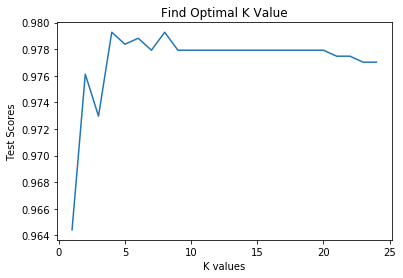

In [55]:
import matplotlib.pyplot as plt
scores = []
for k in range(1,25):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))
plt.plot(range(1,25), scores)
plt.xlabel("K values")
plt.ylabel("Test Scores")
plt.title("Find Optimal K Value")

plt.show()

The optimal K value seems to be around 4 or 8, with the values leveling off before decreasing aroung 10.